## Aircraft Engine Failure Prediction

This file includes steps to build a LSTM Model. Since any deep learning models require many hyperparameters, finding out the perfect architecture is very important. While there is no specific method for model architecture, We can rely on some rule of thumbs.

I follow tips suggested in this article: https://towardsdatascience.com/17-rules-of-thumb-for-building-a-neural-network-93356f9930af

### Importing Required Libraries and Data

In [61]:
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import time
import os
os.chdir("C:/Data/aircraft/")

from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score

#for deep learning
import keras
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Masking, Dropout
from keras.optimizers import RMSprop,adam
from keras.callbacks import History
from keras import callbacks

In [2]:
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

    cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10', 'SensorMeasure14',
     'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']

    df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)
    
    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)

    y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index
    
    return df_train, df_test, y_true

In [3]:
df_train, df_test, y_true = prepare_data()
df_train.shape, df_test.shape, y_true.shape

((20631, 18), (13096, 17), (100, 2))

In [4]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL'])

In [5]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))

df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.transform(df_test[feats])

In [6]:
df_train['failure'] = [1 if i < 50 else 0 for i in df_train.RUL]
y_true['failure'] = [1 if i < 50 else 0 for i in y_true.RUL]

In [7]:
df_train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21,RUL,failure
0,1,1,-0.080460,-0.666667,-0.632530,-0.186396,-0.380486,0.452496,-0.515152,-0.780490,-0.261905,0.266525,-0.588235,-0.272028,-0.333333,0.426357,0.449323,191,0
1,1,2,0.218391,-0.500000,-0.433735,-0.093961,-0.294733,0.256039,-0.575758,-0.799515,-0.238095,0.530917,-0.441176,-0.177376,-0.333333,0.333333,0.462027,190,0
2,1,3,-0.494253,0.500000,-0.313253,-0.260955,-0.258947,0.420290,-0.454545,-0.719914,-0.500000,0.590618,-0.558824,-0.285110,-0.666667,0.255814,0.242751,189,0
3,1,4,0.080460,0.000000,-0.313253,-0.487683,-0.337610,0.481481,-0.363636,-0.750965,-0.666667,0.778252,-0.411765,-0.666795,-0.333333,0.147287,0.324772,188,0
4,1,5,-0.218391,-0.333333,-0.301205,-0.485066,-0.190749,0.336554,-0.515152,-0.700081,-0.488095,0.492537,-0.529412,-0.195845,-0.166667,0.178295,0.409003,187,0


In [8]:
df_test.head()

,UnitNumber,Cycle,OpSet1,OpSet2,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21
0,1,1,0.264368,0.500000,0.090361,-0.378679,-0.461175,0.304348,-0.575758,-0.744773,-0.583333,0.292111,-0.558824,-0.382070,-0.333333,0.116279,0.323667
1,1,2,-0.310345,-0.500000,-0.698795,-0.240898,-0.555368,0.610306,-0.666667,-0.706632,-0.226190,0.479744,-0.470588,-0.573682,-0.166667,0.364341,0.373654
2,1,3,0.034483,0.166667,-0.246988,-0.306736,-0.355503,0.371981,-0.545455,-0.683837,-0.226190,0.398721,-0.558824,-0.082724,-0.166667,0.457364,0.442695
3,1,4,0.482759,0.000000,-0.259036,-0.429693,-0.183997,0.359098,-0.606061,-0.788567,-0.488095,0.147122,-0.500000,-0.485956,-0.500000,0.333333,0.324220
4,1,5,0.160920,0.000000,-0.216867,-0.295836,-0.335922,0.388084,-0.666667,-0.795208,-0.452381,0.475480,-0.558824,-0.398230,-0.666667,0.317829,0.432753


In [9]:
y_true.head()

,RUL,UnitNumber,failure
0,112,0,0
1,98,1,0
2,69,2,0
3,82,3,0
4,91,4,0



LSTM expects an input in the shape of a numpy array of 3 dimensions and I will need to convert train and test data accordingly.

In [10]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

In [11]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [12]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value
    
    id_df = df_mask.append(id_df,ignore_index=True)
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    start = num_elements-seq_length
    stop = num_elements
    
    lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)


Let's define look back period and mask_value

In [13]:
sequence_length = 50 #predicting using last 30 cycle values
mask_value = 0


Let's prepare data using above functions.

In [14]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(15731, 50, 15)


In [15]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "failure")) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(15731,)

In [16]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 50, 15)


In [17]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape

(100,)

In [18]:
nb_features = x_train.shape[2]
nb_out = 1

In [19]:
nb_features

15

In [20]:
class_0 = pd.Series(y_train).value_counts()[0]
class_1 = pd.Series(y_train).value_counts()[1]
total = class_0 + class_1

cls_wt = {0: class_1/total, 1: class_0/total}

In [21]:
cls_wt

{0: 0.3178437480134766, 1: 0.6821562519865234}

### Function to Print Results

In [22]:
def print_results(y_test, y_pred):
    
    #f1-score
    f1 = f1_score(y_test, y_pred)
    print("F1 Score: ", f1)
    print(classification_report(y_true.failure, y_pred))
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
    b, t = plt.ylim()
    plt.ylim(b + 0.5, t - 0.5)
    plt.title('Confuion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')

    #roc_auc_score
    model_roc_auc = roc_auc_score(y_test, y_pred) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(y_test, y_pred)
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    threshold = np.round(thresholds[ix],3)

    plt.subplot(222)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

### Model with 1 hidden layer

#### Model 1

In [23]:
history = History()

model1 = Sequential()
model1.add(LSTM(
         units=4,
         return_sequences=False,
         input_shape=(sequence_length, nb_features)))
model1.add(Dense(units=1, activation='sigmoid'))
model1.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

model1.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 320       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 325
Trainable params: 325
Non-trainable params: 0
_________________________________________________________________


In [24]:
%%time
# fit the model
model1.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
          callbacks = [history])

Instructions for updating:
Use tf.cast instead.
Train on 14157 samples, validate on 1574 samples
Epoch 1/100
14157/14157 [==============================] - 15s 1ms/step - loss: 0.2131 - acc: 0.8437 - val_loss: 0.1540 - val_acc: 0.8755
Epoch 2/100
14157/14157 [==============================] - 12s 868us/step - loss: 0.1330 - acc: 0.8903 - val_loss: 0.1192 - val_acc: 0.8812
Epoch 3/100
14157/14157 [==============================] - 14s 971us/step - loss: 0.1084 - acc: 0.9047 - val_loss: 0.1119 - val_acc: 0.8793
Epoch 4/100
14157/14157 [==============================] - 13s 911us/step - loss: 0.0982 - acc: 0.9183 - val_loss: 0.1064 - val_acc: 0.8945
Epoch 5/100
14157/14157 [==============================] - 12s 814us/step - loss: 0.0883 - acc: 0.9280 - val_loss: 0.0933 - val_acc: 0.9136
Epoch 6/100
14157/14157 [==============================] - 12s 839us/step - loss: 0.0838 - acc: 0.9326 - val_loss: 0.0960 - val_acc: 0.9111
Epoch 7/100
14157/14157 [==============================] - 13s 90

14157/14157 [==============================] - 12s 876us/step - loss: 0.0321 - acc: 0.9715 - val_loss: 0.0684 - val_acc: 0.9466
Epoch 56/100
14157/14157 [==============================] - 12s 859us/step - loss: 0.0344 - acc: 0.9691 - val_loss: 0.0795 - val_acc: 0.9396
Epoch 57/100
14157/14157 [==============================] - 12s 816us/step - loss: 0.0331 - acc: 0.9708 - val_loss: 0.0771 - val_acc: 0.9403
Epoch 58/100
14157/14157 [==============================] - 13s 937us/step - loss: 0.0343 - acc: 0.9701 - val_loss: 0.0708 - val_acc: 0.9422
Epoch 59/100
14157/14157 [==============================] - 13s 943us/step - loss: 0.0307 - acc: 0.9739 - val_loss: 0.0763 - val_acc: 0.9403: 0.0306 - acc: 0.97
Epoch 60/100
14157/14157 [==============================] - 14s 973us/step - loss: 0.0299 - acc: 0.9734 - val_loss: 0.0719 - val_acc: 0.9428
Epoch 61/100
14157/14157 [==============================] - 10s 700us/step - loss: 0.0310 - acc: 0.9721 - val_loss: 0.0733 - val_acc: 0.9403
Epoch 

Text(0.5, 1.0, 'Loss')

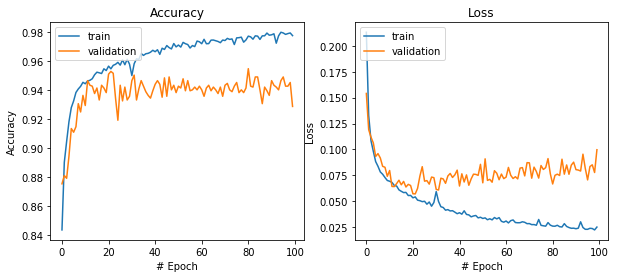

In [28]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# Accuracy
ax[0].plot(history.history['acc'])
ax[0].plot(history.history['val_acc'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

F1 Score:  0.9375
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        70
           1       0.88      1.00      0.94        30

    accuracy                           0.96       100
   macro avg       0.94      0.97      0.95       100
weighted avg       0.96      0.96      0.96       100

Area under curve :  0.9714285714285714 



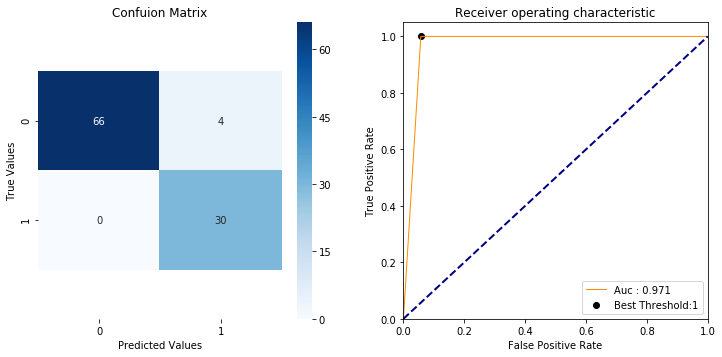

In [26]:
y_pred = model1.predict_classes(x_test)

print_results(y_true.failure, y_pred)

In [27]:
confusion_matrix(y_train, model1.predict_classes(x_train))

array([[10298,   433],
       [   62,  4938]], dtype=int64)

Eventhough we get very good results, there is an overfitting which can be seen in the Loss graph. After 25 epochs, the loss of validation set is increasing and loss of training set keeps on decreasing. Also, the accuracy of validation set remains constant after 25 epochs.

#### Model 2

Model 2 is same as Model 1 but the early stopping is implemented to stop overfitting. 

In [29]:
history = History()

model2 = Sequential()
model2.add(LSTM(
         units=4,
         return_sequences=False,
         input_shape=(sequence_length, nb_features)))
model2.add(Dense(units=1, activation='sigmoid'))
model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 4)                 320       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 325
Trainable params: 325
Non-trainable params: 0
_________________________________________________________________


In [31]:
%%time
# fit the model
model2.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
          callbacks = [history,
                       keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Train on 14157 samples, validate on 1574 samples
Epoch 1/100
14157/14157 [==============================] - 16s 1ms/step - loss: 0.2193 - acc: 0.8452 - val_loss: 0.1673 - val_acc: 0.8971
Epoch 2/100
14157/14157 [==============================] - 13s 945us/step - loss: 0.1499 - acc: 0.8996 - val_loss: 0.1403 - val_acc: 0.8907
Epoch 3/100
14157/14157 [==============================] - 13s 947us/step - loss: 0.1219 - acc: 0.9140 - val_loss: 0.1130 - val_acc: 0.9155
Epoch 4/100
14157/14157 [==============================] - 13s 923us/step - loss: 0.1043 - acc: 0.9277 - val_loss: 0.0993 - val_acc: 0.9269
Epoch 5/100
14157/14157 [==============================] - 13s 934us/step - loss: 0.0939 - acc: 0.9339 - val_loss: 0.0924 - val_acc: 0.9282
Epoch 6/100
14157/14157 [==============================] - 15s 1ms/step - loss: 0.0873 - acc: 0.9361 - val_loss: 0.0896 - val_acc: 0.9295
Epoch 7/100
14157/14157 [==============================] - 13s 934us/step - loss: 0.0818 - acc: 0.9398 - val_loss: 

14157/14157 [==============================] - 6s 445us/step - loss: 0.0317 - acc: 0.9684 - val_loss: 0.0415 - val_acc: 0.9416
Epoch 59/100
14157/14157 [==============================] - 6s 417us/step - loss: 0.0317 - acc: 0.9707 - val_loss: 0.0428 - val_acc: 0.9473
Epoch 60/100
14157/14157 [==============================] - 6s 402us/step - loss: 0.0309 - acc: 0.9696 - val_loss: 0.0501 - val_acc: 0.9416
Epoch 61/100
14157/14157 [==============================] - 6s 411us/step - loss: 0.0303 - acc: 0.9701 - val_loss: 0.0422 - val_acc: 0.9460
Epoch 62/100
14157/14157 [==============================] - 7s 465us/step - loss: 0.0302 - acc: 0.9695 - val_loss: 0.0432 - val_acc: 0.9454
Epoch 63/100
14157/14157 [==============================] - 6s 438us/step - loss: 0.0296 - acc: 0.9718 - val_loss: 0.0431 - val_acc: 0.9473
Wall time: 8h 15min 31s


Text(0.5, 1.0, 'Loss')

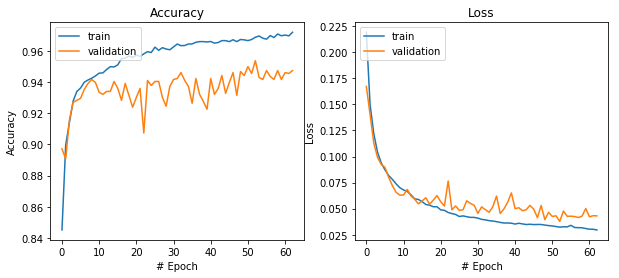

In [32]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# Accuracy
ax[0].plot(history.history['acc'])
ax[0].plot(history.history['val_acc'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

F1 Score:  0.8923076923076922
              precision    recall  f1-score   support

           0       0.98      0.91      0.95        70
           1       0.83      0.97      0.89        30

    accuracy                           0.93       100
   macro avg       0.91      0.94      0.92       100
weighted avg       0.94      0.93      0.93       100

Area under curve :  0.9404761904761906 



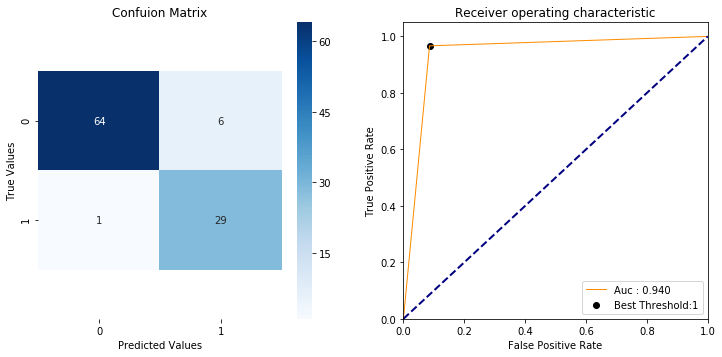

In [39]:
y_pred = model2.predict_classes(x_test)

print_results(y_true.failure, y_pred)

In [40]:
confusion_matrix(y_train, model2.predict_classes(x_train))

array([[10410,   321],
       [  135,  4865]], dtype=int64)

#### Model 3

Model 3 is same as Model 2 but dropout is added to further reduce overfitting. 

In [35]:
history = History()

model3 = Sequential()
model3.add(LSTM(
         units=4,
         return_sequences=False,
         input_shape=(sequence_length, nb_features)))
model3.add(Dropout(0.25))
model3.add(Dense(units=1, activation='sigmoid'))
model3.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

model3.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 4)                 320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 325
Trainable params: 325
Non-trainable params: 0
_________________________________________________________________


In [41]:
%%time
# fit the model
model3.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
          callbacks = [history,
                       keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Train on 14157 samples, validate on 1574 samples
Epoch 1/100
14157/14157 [==============================] - 13s 944us/step - loss: 0.1078 - acc: 0.9231 - val_loss: 0.1294 - val_acc: 0.8850
Epoch 2/100
14157/14157 [==============================] - 14s 958us/step - loss: 0.1022 - acc: 0.9246 - val_loss: 0.1182 - val_acc: 0.9022
Epoch 3/100
14157/14157 [==============================] - 14s 964us/step - loss: 0.0985 - acc: 0.9287 - val_loss: 0.1069 - val_acc: 0.9072
Epoch 4/100
14157/14157 [==============================] - 14s 959us/step - loss: 0.0916 - acc: 0.9333 - val_loss: 0.0995 - val_acc: 0.9161
Epoch 5/100
14157/14157 [==============================] - 14s 959us/step - loss: 0.0886 - acc: 0.9337 - val_loss: 0.1040 - val_acc: 0.8977
Epoch 6/100
14157/14157 [==============================] - 14s 967us/step - loss: 0.0826 - acc: 0.9359 - val_loss: 0.0929 - val_acc: 0.9155
Epoch 7/100
14157/14157 [==============================] - 14s 966us/step - loss: 0.0805 - acc: 0.9360 - val_lo

Text(0.5, 1.0, 'Loss')

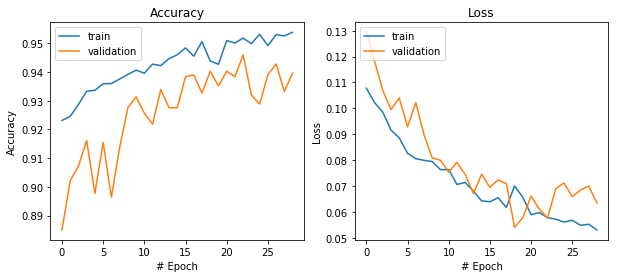

In [44]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# Accuracy
ax[0].plot(history.history['acc'])
ax[0].plot(history.history['val_acc'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

F1 Score:  0.9206349206349207
              precision    recall  f1-score   support

           0       0.99      0.94      0.96        70
           1       0.88      0.97      0.92        30

    accuracy                           0.95       100
   macro avg       0.93      0.95      0.94       100
weighted avg       0.95      0.95      0.95       100

Area under curve :  0.9547619047619048 



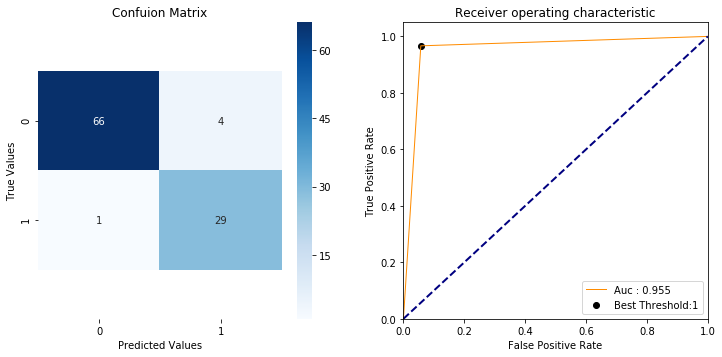

In [45]:
y_pred = model3.predict_classes(x_test)

print_results(y_true.failure, y_pred)

In [46]:
confusion_matrix(y_train, model3.predict_classes(x_train))

array([[10306,   425],
       [  214,  4786]], dtype=int64)

#### Model 4

Model 4 has two hidden layers to learn complex patterns in the data.

In [47]:
history = History()

model4 = Sequential()
model4.add(LSTM(
         units=8,
         return_sequences=True,
         input_shape=(sequence_length, nb_features)))
model4.add(Dropout(0.2))
model4.add(LSTM(
         units=4,
         return_sequences=False))
model4.add(Dropout(0.2))
model4.add(Dense(units=1, activation='sigmoid'))
model4.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50, 8)             768       
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 8)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dropout_3 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


In [48]:
%%time
# fit the model
model4.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
          callbacks = [history,
                       keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Train on 14157 samples, validate on 1574 samples
Epoch 1/100
14157/14157 [==============================] - 28s 2ms/step - loss: 0.1768 - acc: 0.8827 - val_loss: 0.1422 - val_acc: 0.8710
Epoch 2/100
14157/14157 [==============================] - 24s 2ms/step - loss: 0.1097 - acc: 0.9196 - val_loss: 0.0770 - val_acc: 0.9384
Epoch 3/100
14157/14157 [==============================] - 23s 2ms/step - loss: 0.0829 - acc: 0.9386 - val_loss: 0.0713 - val_acc: 0.9263
Epoch 4/100
14157/14157 [==============================] - 24s 2ms/step - loss: 0.0717 - acc: 0.9442 - val_loss: 0.0714 - val_acc: 0.9269
Epoch 5/100
14157/14157 [==============================] - 24s 2ms/step - loss: 0.0651 - acc: 0.9501 - val_loss: 0.0638 - val_acc: 0.9371
Epoch 6/100
14157/14157 [==============================] - 24s 2ms/step - loss: 0.0614 - acc: 0.9520 - val_loss: 0.0642 - val_acc: 0.9269
Epoch 7/100
14157/14157 [==============================] - 24s 2ms/step - loss: 0.0561 - acc: 0.9544 - val_loss: 0.0628 - v

Text(0.5, 1.0, 'Loss')

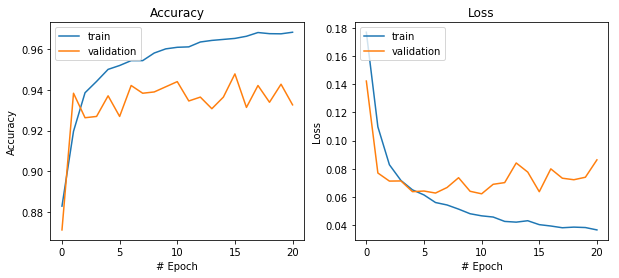

In [49]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# Accuracy
ax[0].plot(history.history['acc'])
ax[0].plot(history.history['val_acc'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

F1 Score:  0.923076923076923
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        70
           1       0.86      1.00      0.92        30

    accuracy                           0.95       100
   macro avg       0.93      0.96      0.94       100
weighted avg       0.96      0.95      0.95       100

Area under curve :  0.9642857142857143 



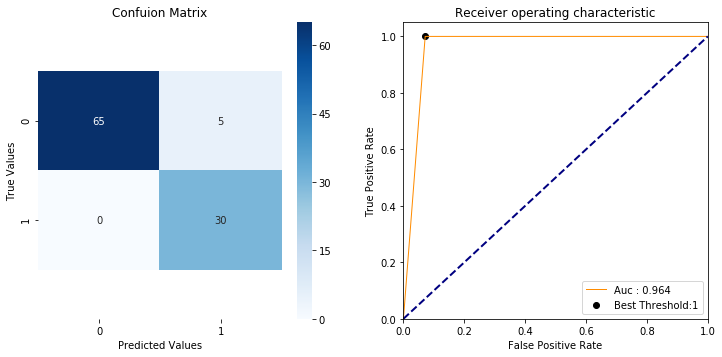

In [52]:
y_pred = model4.predict_classes(x_test)

print_results(y_true.failure, y_pred)

In [53]:
confusion_matrix(y_train, model4.predict_classes(x_train))

array([[10276,   455],
       [  107,  4893]], dtype=int64)

#### False Positives Analysis

In [55]:
y_true['pred'] = y_pred
y_true.head()

,RUL,UnitNumber,failure,pred
0,112,0,0,0
1,98,1,0,0
2,69,2,0,1
3,82,3,0,0
4,91,4,0,0


In [56]:
y_true[y_true.failure != y_true.pred]

,RUL,UnitNumber,failure,pred
2,69,2,0,1
61,54,61,0,1
62,72,62,0,1
83,58,83,0,1
92,85,92,0,1


The RUL for False positives is near to 50 cycles only.

### Experiment

LSTM models have stochasticity and the results might be different everytime. I run the model (architecture same as mdoel 4) 10 times and check the performance of model.

In [57]:
def run_exp_model(X, y, X_test, y_test, nruns = 10):
    
    """
    Parameters:
    X, y = training pandas dataframe
    X_test, y_test = testing pandas dataframe
    nruns = number of time the models should rn
    
    return:
    Dataframe with Model Run, Accuracy, Precision, Recall, F1 Score, AUC Score
    """
    
    score_df = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1 score", "AUC Score"])

    for i in range(0, nruns):
        start = time.time()

        model = Sequential()
        model.add(LSTM(
                 units=8,
                 return_sequences=True,
                 input_shape=(sequence_length, nb_features)))
        model.add(Dropout(0.2))
        model.add(LSTM(
                  units=4,
                  return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(units=1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy', optimizer = "adam", metrics=["accuracy"])

        model.fit(X, y, epochs=100, batch_size=64, validation_split = 0.1, verbose=0, class_weight=cls_wt,
              shuffle= True ,callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                                                                  verbose=0, mode='auto')])

        predictions = model.predict_classes(X_test)

        acc = accuracy_score(y_test,predictions)
        pr = precision_score(y_test,predictions)
        rc = recall_score(y_test,predictions)
        f1 = f1_score(y_test,predictions)
        auc = roc_auc_score(y_test,predictions)

        score_df = score_df.append({'Model':i + 1, 'Accuracy': acc, 'Precision': pr, 'Recall': rc,
                                    'F1 Score': f1, 'AUC Score': auc}, ignore_index=True)
        end = time.time()
        print("Run:", i+1, " and Runtime:", np.round(end - start, 3), " Seconds", sep = "")        
    
    return score_df

In [62]:
result_df = run_exp_model(x_train, y_train, x_test, y_true.failure, nruns = 10)

Run:1 and Runtime:502.499 Seconds
Run:2 and Runtime:228.779 Seconds
Run:3 and Runtime:233.553 Seconds
Run:4 and Runtime:251.012 Seconds
Run:5 and Runtime:339.89 Seconds
Run:6 and Runtime:271.501 Seconds
Run:7 and Runtime:481.365 Seconds
Run:8 and Runtime:256.01 Seconds
Run:9 and Runtime:360.233 Seconds
Run:10 and Runtime:361.427 Seconds


In [81]:
result_df

,Model,Accuracy,Precision,Recall,AUC Score,F1 Score
0,1.0,0.97,0.909091,1.0,0.978571,0.952381
1,2.0,0.97,0.909091,1.0,0.978571,0.952381
2,3.0,0.98,0.937500,1.0,0.985714,0.967742
3,4.0,0.96,0.882353,1.0,0.971429,0.937500
4,5.0,0.97,0.909091,1.0,0.978571,0.952381
5,6.0,0.96,0.882353,1.0,0.971429,0.937500
6,7.0,0.98,0.937500,1.0,0.985714,0.967742
7,8.0,0.95,0.857143,1.0,0.964286,0.923077
8,9.0,0.99,0.967742,1.0,0.992857,0.983607
9,10.0,0.97,0.909091,1.0,0.978571,0.952381


Text(0, 0.5, 'Value')

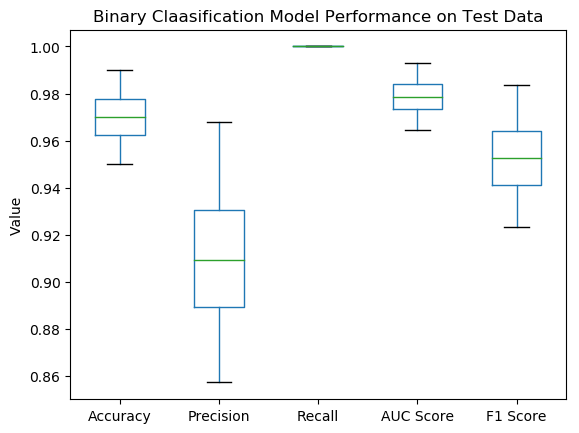

In [86]:
fig, ax = plt.subplots()
result_df.drop(['Model'], axis = 1).boxplot(vert = 1, ax = ax)
ax.set_title('Binary Claasification Model Performance on Test Data')
ax.grid(b=None)
ax.set_ylabel('Value')

In [83]:
result_df.mean()

Model        5.500000
Accuracy     0.970000
Precision    0.910095
Recall       1.000000
AUC Score    0.978571
F1 Score     0.952669
dtype: float64